In [2]:
import numpy as np
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM,Dense,Dropout,GRU,Conv1D,InputLayer
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

### Get the data

In [3]:
dfRaw = pd.read_csv('bitcoin.csv')
dfRaw.sort_values(by='time_period_start',inplace=True)
dfRaw = dfRaw[dfRaw.columns[4:]]
df = dfRaw.values

### Create the data sets

In [4]:
tempX= []
tempY = []
for i in range(60,len(df)):
    tempX.append(list(df[i-60:i,:].reshape(1,-1).squeeze()))
    tempY.append(df[i][1])

### Normalize the Data using MinMaxScaler

In [6]:
scX = MinMaxScaler(feature_range = (0, 1))
scY = MinMaxScaler(feature_range = (0, 1))

transformedX = scX.fit_transform(tempX) 
transformedY = scY.fit_transform(np.array(tempY).reshape(-1,1))
transformedX = transformedX.reshape(transformedX.shape[0], transformedX.shape[1], 1)

### Create train and test sets

In [7]:
cut = int(.95*len(df))
X_train = transformedX[:cut]
X_test = transformedX[cut:]
y_train = transformedY[:cut]
y_test = transformedY[cut:]

### Train LTSM Model

In [46]:
modelLTSM = Sequential()
modelLTSM.add(LSTM(units=75, return_sequences=True, input_shape=(X_train.shape[1], 1),dropout=.25))
modelLTSM.add(LSTM(units=75,dropout=.25))
modelLTSM.add(Dense(units=1))
modelLTSM.compile(optimizer='adam',loss='mean_squared_error')
modelLTSM.fit(X_train, y_train, epochs=12, batch_size=50)

Epoch 1/12
190/190 [==============================] - 97s 497ms/step - loss: 0.0188
Epoch 2/12
190/190 [==============================] - 95s 502ms/step - loss: 0.0028
Epoch 3/12
190/190 [==============================] - 99s 520ms/step - loss: 0.0022
Epoch 4/12
190/190 [==============================] - 102s 536ms/step - loss: 0.0019
Epoch 5/12
190/190 [==============================] - 101s 532ms/step - loss: 0.0017
Epoch 6/12
190/190 [==============================] - 102s 536ms/step - loss: 0.0019
Epoch 7/12
190/190 [==============================] - 101s 532ms/step - loss: 0.0016
Epoch 8/12
190/190 [==============================] - 102s 539ms/step - loss: 0.0016
Epoch 9/12
190/190 [==============================] - 103s 541ms/step - loss: 0.0015
Epoch 10/12
190/190 [==============================] - 104s 545ms/step - loss: 0.0016
Epoch 11/12
190/190 [==============================] - 102s 538ms/step - loss: 0.0014
Epoch 12/12
190/190 [==============================] - 102s 538ms/

### Create GRU Model

In [47]:
modelGRU = Sequential()
modelGRU.add(GRU(units=75, return_sequences=True, input_shape=(X_train.shape[1], 1),dropout=.25))
modelGRU.add(GRU(units=75,dropout=.25))
modelGRU.add(Dense(units=1))
modelGRU.compile(optimizer='adam',loss='mean_squared_error')
modelGRU.fit(X_train, y_train, epochs=12, batch_size=50)

Epoch 1/12
190/190 [==============================] - 73s 378ms/step - loss: 0.0241
Epoch 2/12
190/190 [==============================] - 72s 379ms/step - loss: 0.0030
Epoch 3/12
190/190 [==============================] - 70s 371ms/step - loss: 0.0015
Epoch 4/12
190/190 [==============================] - 71s 372ms/step - loss: 0.0013
Epoch 5/12
190/190 [==============================] - 70s 369ms/step - loss: 0.0011
Epoch 6/12
190/190 [==============================] - 70s 369ms/step - loss: 0.0011
Epoch 7/12
190/190 [==============================] - 71s 373ms/step - loss: 0.0011
Epoch 8/12
190/190 [==============================] - 73s 382ms/step - loss: 0.0011
Epoch 9/12
190/190 [==============================] - 73s 385ms/step - loss: 9.8586e-04
Epoch 10/12
190/190 [==============================] - 72s 379ms/step - loss: 9.1352e-04
Epoch 11/12
190/190 [==============================] - 72s 380ms/step - loss: 8.5932e-04
Epoch 12/12
190/190 [==============================] - 72s 381

### Get Predictions and reverse the normalization

In [52]:
predictedLTSM = list(scY.inverse_transform(modelLTSM.predict(X_test)).reshape(1,-1).squeeze())
predictedGRU = list(scY.inverse_transform(modelGRU.predict(X_test)).reshape(1,-1).squeeze())
prices = list(scY.inverse_transform(y_test).reshape(1,-1).squeeze())

predictedPricesLTSM = list(scY.inverse_transform(modelLTSM.predict(X_train)).reshape(1,-1).squeeze()) + predictedLTSM 
predictedPricesGRU = list(scY.inverse_transform(modelGRU.predict(X_train)).reshape(1,-1).squeeze()) + predictedGRU
actualPrices = dfRaw['price_high'].values[60:]

In [53]:
def plot(actualPrice, predictedPrice,title):
    plt.figure(figsize=(10,5))
    plt.plot(actualPrice, color = 'blue', label = 'Actual')
    plt.plot(predictedPrice, color = 'red', label = 'Predicted')
    plt.title(title)
    plt.xlabel('Seconds')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

### Graphing the predictions from both models

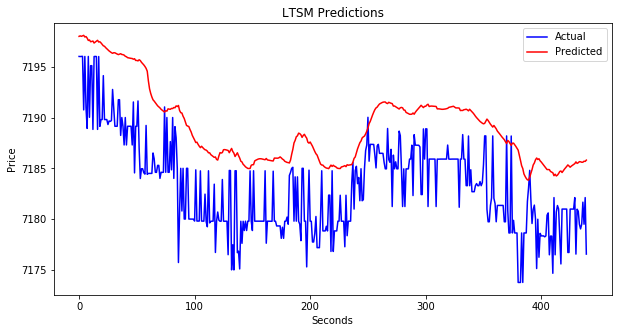

In [54]:
plot(prices, predictedLTSM,'LTSM Predictions')

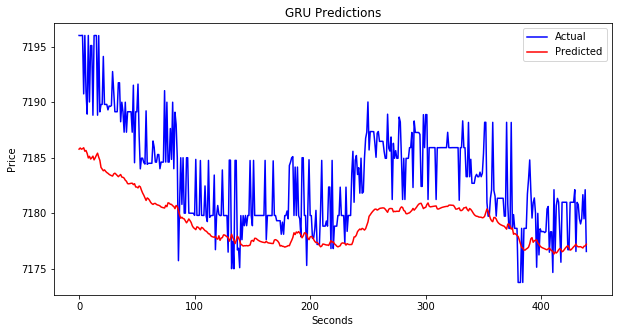

In [55]:
plot(prices, predictedGRU,'GRU Predictions')

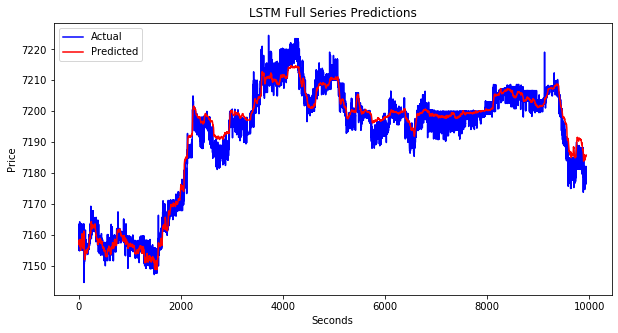

In [56]:
plot(actualPrices, predictedPricesLTSM ,'LSTM Full Series Predictions')

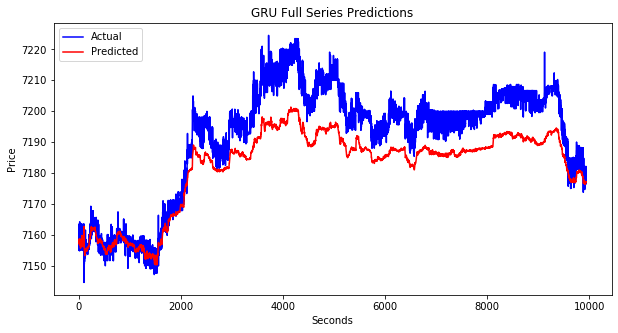

In [57]:
plot(actualPrices, predictedPricesGRU,'GRU Full Series Predictions')

### Corrolation check for aditional model accuracy test (after MSE)

In [ ]:
corrLTSMtest = pd.DataFrame(zip(prices, predictedLTSM)).pct_change(1).dropna().corr()[0][1]
corrGRUtest = pd.DataFrame(zip(prices, predictedGRU)).pct_change(1).dropna().corr()[0][1]
corrLTSMFull = pd.DataFrame(zip(actualPrices, predictedPricesLTSM)).pct_change(1).dropna().corr()[0][1]
corrGRUFull = pd.DataFrame(zip(actualPrices, predictedPricesGRU)).pct_change(1).dropna().corr()[0][1]

In [65]:
print('Corrolation of LSTM predicted values with realized values: {}'.format(corrLTSMtest))
print('Corrolation of GRU predicted values with realized values: {}'.format(corrGRUtest))
print('Corrolation of LSTM full series predicted values with full series realized values: {}'.format(corrLTSMFull))
print('Corrolation ofGRU full series predicted values with full series realized values: {}'.format(corrGRUFull))

Corrolation of LSTM predicted values with realized values: -0.40124837643374184
Corrolation of GRU predicted values with realized values: -0.5214103911160306
Corrolation of LSTM full series predicted values with full series realized values: -0.4119991739927571
Corrolation ofGRU full series predicted values with full series realized values: -0.49946718934342693
